In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torchvision.models as models

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Importing all Data

In [0]:
file_id = '1clW0YfAknvC6fS3i-yzGceq-l3XaXsG0'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("recognition_real_dataset.tar.7z")

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

In [0]:
!7z x recognition_real_dataset.tar.7z
#!tar -xvf /content/recognition_real_dataset.tar


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 30326570 bytes (29 MiB)

Extracting archive: recognition_real_dataset.tar.7z
--
Path = recognition_real_dataset.tar.7z
Type = 7z
Physical Size = 30326570
Headers Size = 134
Method = LZMA:24
Solid = -
Blocks = 1

  0%     10%     20% - cropped_data.tar                        31% - cropped_data.tar                        41% - cropped_data.tar                        50% - cropped_data.tar                        62% - cropped_data.tar                        72% - cropped_data.t

In [0]:
!tar -xvf /content/cropped_data.tar

cropped_data/
cropped_data/annotations.txt
cropped_data/readme.txt
cropped_data/cropped_dir/
cropped_data/cropped_dir/1191.jpg
cropped_data/cropped_dir/119.jpg
cropped_data/cropped_dir/1184.jpg
cropped_data/cropped_dir/1183.jpg
cropped_data/cropped_dir/1182.jpg
cropped_data/cropped_dir/1181.jpg
cropped_data/cropped_dir/118.jpg
cropped_data/cropped_dir/1179.jpg
cropped_data/cropped_dir/1174.jpg
cropped_data/cropped_dir/1171.jpg
cropped_data/cropped_dir/1170.jpg
cropped_data/cropped_dir/1169.jpg
cropped_data/cropped_dir/1167.jpg
cropped_data/cropped_dir/1166.jpg
cropped_data/cropped_dir/1164.jpg
cropped_data/cropped_dir/1163.jpg
cropped_data/cropped_dir/1161.jpg
cropped_data/cropped_dir/1160.jpg
cropped_data/cropped_dir/116.jpg
cropped_data/cropped_dir/1158.jpg
cropped_data/cropped_dir/1157.jpg
cropped_data/cropped_dir/1156.jpg
cropped_data/cropped_dir/1155.jpg
cropped_data/cropped_dir/1154.jpg
cropped_data/cropped_dir/1153.jpg
cropped_data/cropped_dir/1152.jpg
cropped_data/cropped_dir/1

In [0]:
%cat /content/cropped_data/readme.txt

- Cropped_dir consist of 1740 cropped word images.
- The ground truth detail is presents in the annotation.txt file.
- Annotation.txt list location of the image file (relative to parent cropped_dir), followed ground truth, followed by parent file location, followed by location from where it is cropped in parent. All information is sepreated by the tab '\t'.
- Only single language is there that is hindi.




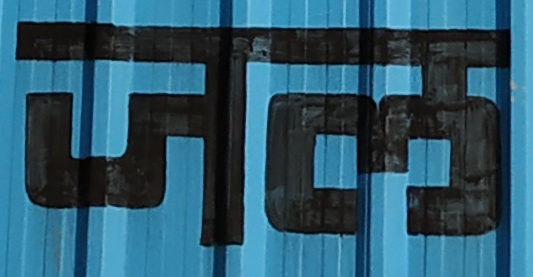

In [0]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread("/content/cropped_data/cropped_dir/0.jpg")
cv2_imshow(img)

#Obtaining Hindi letters and converting them into an OHE Representation

In [0]:
hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)
pad_char = '-PAD-'
hindi_alpha2index = {0:pad_char}
hindi_alpha2index2 = {pad_char:0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[index+1] = alpha
    hindi_alpha2index2[alpha] = index + 1
print(len(hindi_alpha2index2))

129


In [0]:

hindi_alphabets_str = ''
for i in hindi_alphabets:
  hindi_alphabets_str += i 
hindi_alphabets_str

'ऀँंःऄअआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळऴवशषसहऺऻ़ऽािीुूृॄॅॆेैॉॊोौ्ॎॏॐ॒॑॓॔ॕॖॗक़ख़ग़ज़ड़ढ़फ़य़ॠॡॢॣ।॥०१२३४५६७८९॰ॱॲॳॴॵॶॷॸॹॺॻॼॽॾॿ'

In [0]:
hindi_alphabets_arr = list(hindi_alpha2index.keys())

#Creating a CNN Feature Map

##Obtaining the Training Data

In [0]:
import csv
file_data = []
with open("/content/cropped_data/annotations.txt") as fd:
  rd = csv.reader(fd,delimiter = "\t",quotechar = '"')
  for row in rd:
    file_data.append(row)
    
  print("Annotations Extracted Successfully!")
  print(file_data[1436][1])

Annotations Extracted Successfully!
के


In [0]:
training_data = []
img_width = 200
img_ht = 150
DATADIR = "/content/cropped_data/cropped_dir"
def create_training_data(DATADIR):
  path = DATADIR 
  print("Number of images in the path = ",(len(os.listdir(path))))
  #print(os.listdir(path)[0])
  for img in os.listdir(path):
      #try:
      img_array = cv2.imread(path+"/"+img)
      img_array = cv2.resize(img_array,(img_width,img_ht))
      img = img.split('.')
      training_data.append([img_array,file_data[int(img[0])][1]])
      
      #except Exception as e:
      #  pass
  print("Training Data Built Successfully")
  return training_data

training_data = create_training_data(DATADIR)

Number of images in the path =  1740
Training Data Built Successfully


Image size is normalized here by bringing all the input images to the same size in order to prevent any confusions over different image sizes. 64x64 was taken because most imaages on an average had over 64 in both dimensions and hence reducing their sizes is only bound to increase the clarity to some extent

क्रं


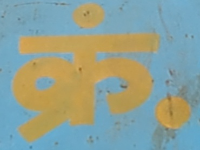

(150, 200, 3)
छात्रावास


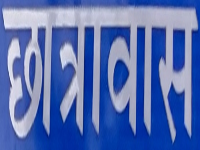

(150, 200, 3)
कालोनी


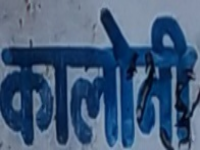

(150, 200, 3)
फेसबुक


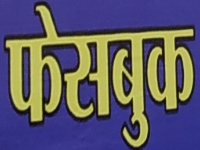

(150, 200, 3)
इटारसी


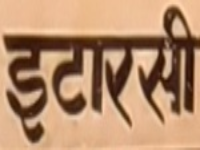

(150, 200, 3)
सेन्टर


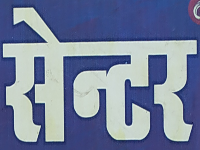

(150, 200, 3)
पढ़ाओ


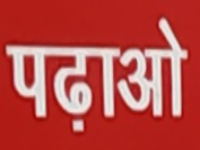

(150, 200, 3)
इटारसी


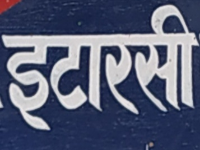

(150, 200, 3)
स्वच्छ


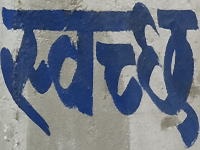

(150, 200, 3)
शरावती


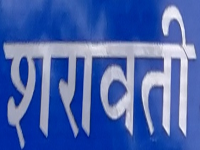

(150, 200, 3)


In [0]:
for i in range(10):
  print(training_data[i][1])
  cv2_imshow(training_data[i][0])
  print(training_data[i][0].shape)

In [0]:
for i in range(10):
  print(training_data[i][0].shape)

(150, 200, 3)
(150, 200, 3)
(150, 200, 3)
(150, 200, 3)
(150, 200, 3)
(150, 200, 3)
(150, 200, 3)
(150, 200, 3)
(150, 200, 3)
(150, 200, 3)


In [0]:
batch_size = 8
full_data = training_data
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size

train_data, validationtest_data = random_split(full_data, [train_size, test_size])
test_size = int(0.5*len(validationtest_data))
validation_data,test_data = random_split(validationtest_data,[test_size, test_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
validationtest_loader = torch.utils.data.DataLoader(validationtest_data, batch_size=batch_size, shuffle=False)



In [0]:

for batch_id, data in enumerate(train_loader):
  inputs, label = data
  print((inputs).shape)
  print(label)
  break


torch.Size([8, 150, 200, 3])
('निकेतन', '४', 'क्लास', 'जाते', 'के', 'स्टोर', 'दल', 'किमी')


##Deep Convnet

In [0]:
class FirstCNN(nn.Module):
  def __init__(self):
    super(FirstCNN,self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3,16,3),
        nn.Conv2d(16,96,3),
        nn.Conv2d(96,256,3),
        nn.MaxPool2d(kernel_size=(1,1)),
        nn.Conv2d(256,512,3),
        #nn.Upsample(scale_factor=1.142857142857143,mode = 'bilinear')
    )
  def forward(self, x):
    x = self.model(x)
    return x
    

Model ran Successfully!
torch.Size([1, 512, 142, 192])


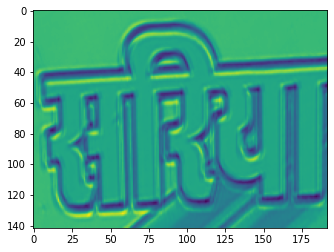

In [0]:
model = FirstCNN()
npimg = np.asarray(training_data[103][0])
new_array = np.transpose(npimg,(2,0,1))
new_array = torch.from_numpy(new_array)
new_array = new_array.type(torch.FloatTensor)
new_array = new_array.unsqueeze(0)
output = model(new_array)
print("Model ran Successfully!")
print(output.shape)
plt.imshow(output[0, 15, :, :].detach().numpy())

In [0]:
class FirstCNNv2(nn.Module):
  def __init__(self):
    super(FirstCNNv2,self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3,8,3),
        nn.Conv2d(8,24,3),
        nn.Conv2d(24,96,3),
        #nn.ReLU(),
        #nn.MaxPool2d(2)
        )
  def forward(self,x):
    x = self.model(x)
    return x

Model ran Successfully!
torch.Size([1, 96, 144, 194])


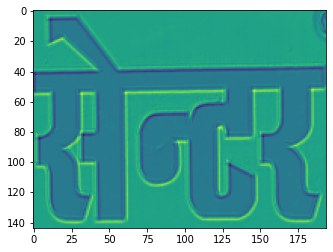

In [0]:
model = FirstCNNv2()
npimg = np.asarray(training_data[5][0])
new_array = np.transpose(npimg,(2,0,1))
new_array = torch.from_numpy(new_array)
new_array = new_array.type(torch.FloatTensor)
new_array = new_array.unsqueeze(0)
output = model(new_array)
print("Model ran Successfully!")
print(output.shape)
plt.imshow(output[0,0, :,:].detach().numpy())

In [0]:
img = output[0,0, :,:].detach().numpy()
img[0,:].shape


(194,)

Model was able to run successfully and we ended up getting getting information off the cnn.
CNN Model did work pretty well to get the info(blue color texts). Lets implement the decoder model now

#Implementation of Decoder Model

##Visualization 
This part is done to check if the given model is by default able to get any image features

In [0]:
from torchvision.models import alexnet,resnet18

###Resnet18

In [0]:
class ResCNN(nn.Module):
    
    def __init__(self):
        super(ResCNN, self).__init__()
        resnet = resnet18(pretrained=True)
        modules = list(resnet.children())[:-3]
        self.resnet = nn.Sequential(*modules)
        self.scaler = nn.Upsample(scale_factor =15.384615384615389)
    
    def forward(self, input): 
        #cnn
        batch_size = input.size(0)
        input = self.resnet(input)
        input = self.scaler(input)
        return input

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



Model ran Successfully!
torch.Size([1, 256, 153, 200])


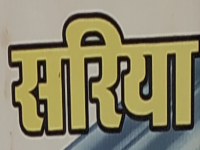

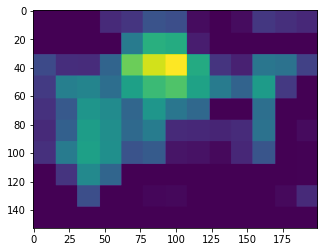

In [0]:
model = ResCNN()
npimg = np.asarray(training_data[103][0])
new_array = np.transpose(npimg,(2,0,1))
new_array = torch.from_numpy(new_array)
new_array = new_array.type(torch.FloatTensor)
new_array = new_array.unsqueeze(0)
output = model(new_array)
print("Model ran Successfully!")
print(output.shape)
plt.imshow(output[0, 5, :, :].detach().numpy())
cv2_imshow(training_data[103][0])

###ResCRNN

In [0]:
MAX_OUTPUT_CHARS = 200 #Width of image
class ResCRNN(nn.Module):
  def __init__(self,input_size,hidden_size,output_size,verbose = False):
    super(ResCRNN,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.verbose = verbose 

    self.cnn = ResCNN()
    
    self.linear1 = nn.Linear(39168,8194)
    self.bn1 = nn.BatchNorm1d(8194)
    self.act = nn.ReLU()
    self.lin2 = nn.Linear(8194,256)
    self.bn2 = nn.BatchNorm1d(200)
    self.act = nn.ReLU()
    self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=2)

  def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        
        #cnn
        batch_size = input.size(0)

        if self.verbose:
          print("Input Size",input.shape)

        input = self.cnn(input)
        inputt = input
        
        if self.verbose:
          print("CNN + Scaler Output",input.shape)
        
        
        
        #encoder
        input = input.permute(0,3,1,2)
        n_channels = input.size(1)
        input = input.view(batch_size,n_channels,-1)
        
        if self.verbose:
          print("Input shape to be sent for lin1",input.shape)
        
        input = self.linear1(input)
        input = self.bn1(input)
        input = self.act(input)
        input = self.lin2(input)
        input = self.bn2(input)
        input = self.act(input)
        out= self.encoder_rnn_cell(input)
        
        if self.verbose:
            print('Encoder input', input.shape)
            print('Encoder output', out[0].shape)
            
        
        outputs = []
    
        out = self.h2o(out[0])
        out = self.softmax(out)
        outputs.append(out.view(1, -1))
        out = out.permute(1,0,2)

        if self.verbose:
            print('GRU  output', out.shape)
            self.verbose = False
        
        return out,inputt

In [0]:
model = ResCRNN(256,512,129,True)
npimg = np.asarray(training_data[100][0])
new_array = np.transpose(npimg,(2,0,1))
new_array = torch.from_numpy(new_array)
new_array = new_array.type(torch.FloatTensor)
new_array = new_array.unsqueeze(0)
output = model(new_array)
print("Model ran Successfully!")
print(output[0].shape)
plt.imshow(output[1][0,1, :,:].detach().numpy())
cv2_imshow(training_data[100][0])

Input Size torch.Size([1, 3, 150, 200])
CNN + Scaler Output torch.Size([1, 256, 153, 200])
Input shape to be sent for lin1 torch.Size([1, 200, 39168])


RuntimeError: ignored

In [0]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [0]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [0]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.features[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.features[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

In [0]:
#visualize weights for resnet - first conv layer

plot_weights(alexnet, 0, single_channel = False)

AttributeError: ignored

In [0]:
print(model)

In [0]:
class Resnet(nn.Module):
    
    def __init__(self,verbose = False):
        super(Resnet, self).__init__()
        resnet = resnet18(pretrained=True)
        modules = list(resnet.children())[:-3]
        self.resnet = nn.Sequential(*modules)
        #self.scaler = nn.Upsample(scale_factor=16,mode = 'bilinear')
        self.verbose = verbose

    def forward(self,input):
      input = self.resnet(input)
      #input = self.scaler(input)
      return input

Model ran Successfully!
torch.Size([1, 256, 10, 13])


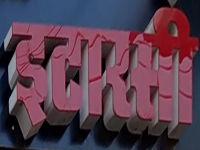

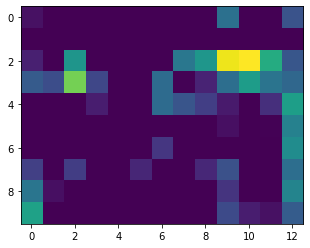

In [0]:
model = Resnet()
npimg = np.asarray(training_data[10][0])
new_array = np.transpose(npimg,(2,0,1))
new_array = torch.from_numpy(new_array)
new_array = new_array.type(torch.FloatTensor)
new_array = new_array.unsqueeze(0)
output = model(new_array)
print("Model ran Successfully!")
print(output.shape)
plt.imshow(output[0,4, :,:].detach().numpy())
cv2_imshow(training_data[10][0])

##Preparing the model
Now that we're done preparing the cnn, we can go ahead and make da fkin model

###MiniCRNN69420

In [0]:
class MiniCRNN69420(nn.Module):
  def __init__(self,input_size, hidden_size, output_size, verbose = False):
    super(MiniCRNN69420,self).__init__()
    
    self.hidden_size = hidden_size
    self.output_size = output_size

    alexnet = torchvision.models.alexnet(pretrained=True)
    self.alexnet = alexnet.features
    self.upsample = nn.Upsample(scale_factor = 4)
    
    self.linear1 = nn.Linear(32768,8192)
    self.lin2 = nn.Linear(8192,256)
    self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=2)
    
    self.verbose = verbose

  def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        
        #cnn
        batch_size = input.size(0)
        input = self.alexnet(input)
        inputt = input
        print("Alexnet INPUT SHAPE",input.shape)
        print("Alexnet Output Shape",input.shape)
        
        
        #print("Input shape after scaling",input.shape)
        
        #encoder
        input = input.permute(0,3,1,2)
        n_channels = input.size(1)
        input = input.view(batch_size,n_channels,-1)
        #print("Input shape to be sent for lin1",input.shape)
        input = self.linear1(input)
        input = self.lin2(input)
        out= self.encoder_rnn_cell(input)
        #print(out[0].shape)
        if self.verbose:
            print('Encoder input', input.shape)
            print('Encoder output', out[0].shape)
            
        
        outputs = []
    
        out = self.h2o(out[0])
        out = self.softmax(out)
        outputs.append(out.view(1, -1))
        out = out.permute(1,0,2)

        if self.verbose:
            print('GRU  output', out.shape)
            self.verbose = False
        
        return out,inputt

In [0]:
model = MiniCRNN69420(256,512,129,verbose = True)
for batch_id, data in enumerate(train_loader):
  inputs, label = data
  print(inputs.shape)
  npimg = (inputs).numpy()
  new_array = np.transpose(npimg,(0,3,2,1))
  new_array = torch.from_numpy(new_array)
  new_array = new_array.type(torch.FloatTensor)
  print(new_array.shape)
  outputs = model(new_array)
  print(label)
  print(outputs[0].shape)
  plt.imshow(outputs[1][0,0,:,:].detach().numpy())
  break

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



torch.Size([8, 150, 200, 3])
torch.Size([8, 3, 200, 150])
Alexnet INPUT SHAPE torch.Size([8, 256, 5, 3])
Alexnet Output Shape torch.Size([8, 256, 5, 3])


RuntimeError: ignored

###MiniRCNNodel

In [0]:
MAX_OUTPUT_CHARS = 64
class MiniRCNNModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super(MiniRCNNModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size

        resnet = resnet18(pretrained=True)
        modules = list(resnet.children())[:-3]
        self.resnet = nn.Sequential(*modules)
        self.scaler = nn.Upsample(scale_factor=16,mode = 'bilinear')
        self.linear1 = nn.Linear(16384,256)
        #self.lin2 = nn.Linear(2048,256)
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.verbose = verbose
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        
        #cnn
        batch_size = input.size(0)
        input = self.resnet(input)
        inputt = input
        #print("Resnet INPUT SHAPE",input.shape)
        #print("Resnet Output Shape",input.shape)
        
        input = self.scaler(input)
        
        #print("Input shape after scaling",input.shape)
        
        #encoder
        input = input.permute(0,3,1,2)
        n_channels = input.size(1)
        input = input.view(batch_size,n_channels,-1)
        #print("Input shape to be sent for lin1",input.shape)
        input = self.linear1(input)
        #input = self.lin2(input)
        out= self.encoder_rnn_cell(input)
        #print(out[0].shape)
        if self.verbose:
            print('Encoder input', input.shape)
            print('Encoder output', out[0].shape)
            
        
        outputs = []
    
        out = self.h2o(out[0])
        out = self.softmax(out)
        outputs.append(out.view(1, -1))
        out = out.permute(1,0,2)

        if self.verbose:
            print('GRU  output', out.shape)
            self.verbose = False
        
        return out,inputt

In [0]:
model = MiniRCNNModel(256,512,129,verbose = True)
for batch_id, data in enumerate(train_loader):
  inputs, label = data
  print(inputs.shape)
  npimg = (inputs).numpy()
  new_array = np.transpose(npimg,(0,3,2,1))
  new_array = torch.from_numpy(new_array)
  new_array = new_array.type(torch.FloatTensor)
  print(new_array.shape)
  outputs = model(new_array)
  print(label)
  print(outputs.shape)
  break

In [0]:
class blockCNN(nn.Module):
    def __init__(self, in_nc, out_nc, kernel_size, padding, stride=1):
        super(blockCNN, self).__init__()
        self.in_nc = in_nc
        self.out_nc = out_nc
        self.kernel_size = kernel_size
        self.padding = padding
        # layers
        self.conv = nn.Conv2d(in_nc, out_nc, 
                              kernel_size=kernel_size, 
                              stride=stride, 
                              padding=padding)
        self.bn = nn.BatchNorm2d(out_nc)
        
    def forward(self, batch, use_bn=False, use_relu=False, 
                use_maxpool=False, maxpool_kernelsize=None):
        """
            in:
                batch - [batch_size, in_nc, H, W]
            out:
                batch - [batch_size, out_nc, H', W']
        """
        batch = self.conv(batch)
        if use_bn:
            batch = self.bn(batch)
        if use_relu:
            batch = F.relu(batch)
        if use_maxpool:
            assert maxpool_kernelsize is not None
            batch = F.max_pool2d(batch, kernel_size=maxpool_kernelsize, stride=2)
        return batch

class blockRNN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, bidirectional, dropout=0):
        super(blockRNN, self).__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.bidirectional = bidirectional
        # layers
        self.gru = nn.GRU(in_size, hidden_size, bidirectional=bidirectional)
        
    def forward(self, batch, add_output=False):
        """
        in array:
            batch - [seq_len , batch_size, in_size]
        out array:
            out - [seq_len , batch_size, out_size]
        """
        batch_size = batch.size(1)
        outputs, hidden = self.gru(batch)
        out_size = int(outputs.size(2) / 2)
        if add_output:
            outputs = outputs[:, :, :out_size] + outputs[:, :, out_size:]
        return outputs

###CRNN

In [0]:
class CRNN(nn.Module):
    def __init__(self, hidden_size: int, 
                 vocab_size: int, 
                 bidirectional: bool = True, 
                 dropout: float = 0.5):
        super(CRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.bidirectional = bidirectional
        # make layers
        # convolutions 
        resnet = resnet18(pretrained=True)
        modules = list(resnet.children())[:-3]
        self.resnet = nn.Sequential(*modules)

        self.cn6 = blockCNN(256, 256, kernel_size=3, padding=1)
        self.scaler = nn.Upsample(scale_factor=16,mode = 'bilinear')
        # RNN + Linear
        self.linear1 = nn.Linear(8192, 4096)
        self.lin2 = nn.Linear(4096,2048)
        self.lin3 = nn.Linear(2048,1024)
        self.lin4 = nn.Linear(1024,256)
        self.gru1 = blockRNN(256, hidden_size, hidden_size,
                             dropout=dropout, 
                             bidirectional=bidirectional)
        self.gru2 = blockRNN(hidden_size, hidden_size, vocab_size,
                             dropout=dropout,
                             bidirectional=bidirectional)
        self.linear2 = nn.Linear(hidden_size * 2, vocab_size)
        
    def forward(self, batch: torch.Tensor):
        """
        ------:size sequence:------
        torch.Size([batch_size, 3, 50, 200]) -- IN:
        torch.Size([batch_size, 256, 4, 13]) -- CNN blocks ended
        torch.Size([batch_size, 13, 256, 4]) -- permuted 
        torch.Size([batch_size, 13, 1024]) -- Linear #1
        torch.Size([batch_size, 13, 256]) -- IN GRU 
        torch.Size([batch_size, 13, 256]) -- OUT GRU 
        torch.Size([batch_size, 13, vocab_size]) -- Linear #2
        torch.Size([13, batch_size, vocab_size]) -- :OUT
        """
        batch_size = batch.size(0)
        print("Batchsize",batch_size)
        # convolutions
        print("Input",batch.shape)
        batchh = self.resnet(batch)
        batch = batchh
        print("After resnet",batch.shape)
        batch = self.cn6(batch, use_relu=True, use_bn=True)
        print("After cn6",batch.shape)
        batch = self.scaler(batch)
        # make sequences of image features
        print("After scaling",batch.shape)
        batch = batch.permute(0, 3, 1, 2)

        n_channels = batch.size(1)
        batch = batch.view(batch_size, n_channels, -1)
        print("After view",batch.shape)
        batch = self.linear1(batch)
        batch = self.lin2(batch)
        batch = self.lin3(batch)
        batch = self.lin4(batch)
        print("After linear1",batch.shape)
        # rnn layers
        batch = self.gru1(batch, add_output=True)
        print("After gru1",batch.shape)
        batch = self.gru2(batch)
        print("After gru2",batch.shape)
        # output
        batch = self.linear2(batch)
        print("After lin2",batch.shape)
        batch = batch.permute(1, 0, 2)
        print("Output",batch.shape)
        return batch,batchh

In [0]:
model = CRNN(256,129,True,0.1)

In [0]:
for batch_id, data in enumerate(train_loader):
  inputs, label = data
  print(inputs.shape)
  npimg = (inputs).numpy()
  new_array = np.transpose(npimg,(0,3,2,1))
  new_array = torch.from_numpy(new_array)
  new_array = new_array.type(torch.FloatTensor)
  print(new_array.shape)
  output = model(new_array)
  print(label)
  print(output[0].shape)
  plt.imshow(output[1][0,0,:,:].detach().numpy())
  break


In [0]:
print(outputs[0].shape)

In [0]:
def get_outputrep(outputs,hindi_alpha2index):
  indices = []
  hindi_op = ''
  for i in range(32):
    _,ind = torch.max(outputs[i][0],0)
    hindi_op += hindi_alpha2index[ind.item()]
  print(hindi_op)


In [0]:
get_outputrep(outputs,hindi_alpha2index)

So this is what we get without training, HMMMMMMMMMMM. Now lets proceed to write a training script

In [0]:
def validation(model, val_losses):
    with torch.no_grad():
        model.eval()
        for batch_img, batch_text in validation_loader:
            npimg = (batch_img).numpy()
            new_array = np.transpose(npimg,(0,3,1,2))
            new_array = torch.from_numpy(new_array)
            new_array = new_array.type(torch.FloatTensor)
            batch_text = batch_text
            logits = model(new_array.to(device))
            val_loss = calculate_loss(logits[0], batch_text)
            val_losses.append(val_loss.item())
    return val_losses

In [0]:
def word_rep(word, letter2index, device = 'cpu'):
    rep = []
    for w in word:
      for letter in w:
        pos = letter2index[letter]
        rep.append(pos)
    rep = torch.Tensor(rep)
    return rep.type(torch.int32)

In [0]:
def calculate_loss(logits, texts):
    # get infomation from prediction
    device = logits.device
    input_len, batch_size, vocab_size = logits.size()
    # encode inputs
    logits = logits.log_softmax(2)
    logits_lens = torch.full(size=(batch_size,), fill_value=input_len, dtype=torch.int32)
    
    encoded_texts = word_rep(texts, hindi_alpha2index2,device)
    text_lens = [len(s) for s in texts]
    text_lens = torch.IntTensor(text_lens)
    '''
    print("Encoded Texts",encoded_texts)
    print("Logits lenghts",logits_lens)
    print("Text lengths",text_lens)
    print("Logits shape",logits.shape)
    print("Texts",texts)
    '''
    #calculate ctc
    loss = criterion(logits, encoded_texts, 
                      logits_lens.to(device), text_lens)
    return loss

In [0]:
batch_size = batch_size
lenght = hindi_alphabet_size
max_epoch = 50

#rcnn = MiniRCNNModel(256,512,129).to(device)

#rcnn = MiniCRNN69420(256,512,129).to(device)

#crnn = CRNN(256,128,True,0.1).to(device)

rcnn = ResCRNN(256,512,129,False).to(device)

#rcnn = crnn

#-----------------------ADADELTA--------------------------
'''
optimizer = torch.optim.Adadelta(rcnn.parameters(),lr =1.0)#As suggested by the paper
criterion = nn.CTCLoss(blank=0)#Used in cases of CRNN Networks which allows both cnn and rnn to be trained
'''

#-----------------------SGD--------------------------------


lr = 0.02
weight_decay = 1e-5
momentum = 0.9
optimizer = torch.optim.SGD(rcnn.parameters(), lr=lr, nesterov=True, 
                            weight_decay=weight_decay, momentum=momentum)
criterion = nn.CTCLoss(blank=0)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)



In [0]:

train_losses = []
val_losses = []
validation_losses = []
val_epoch_len = len(validation_data) // batch_size
val_epoch_len
clip_norm = 5

In [0]:
len(train_data)

1392

##Training

###Observations and ideas

1. try using a pretrained model like resnet instead of cnn you made. Maybe your model isn't getting information (Works better. Pretrained model is able to capture more information)
2. don't use adadelta and scheduler. Adadelta adapts its learning rate and scheduler does that as well which causes the loss to become constant after a while.(Ye adadelta sucks. Going along with sgd itself is fine)
3. try removing scheduler alone and see how it works.(Scheduler and sgd works very well. But scheduler and adadelta no)
4. Try adding attention to the model.
5. Batch size = 8 seems to be the best. Works vvv well with SGD

6/4
1. Figured out that resnet feature map sucks accounting for the model's poor learning capacity and performance
2. Resnet18 works best with pretrained=True and size = 32,32 rn



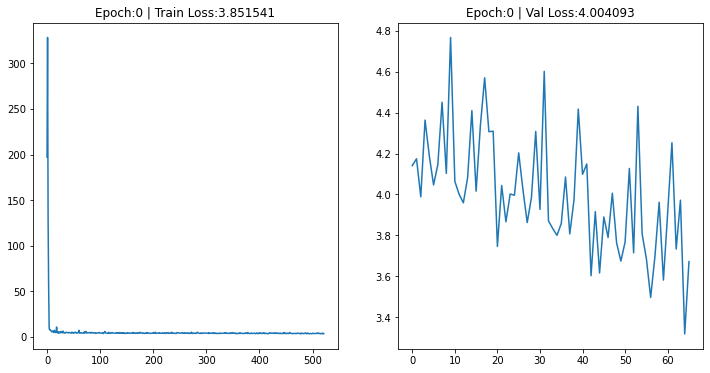

Truth ए Pred 


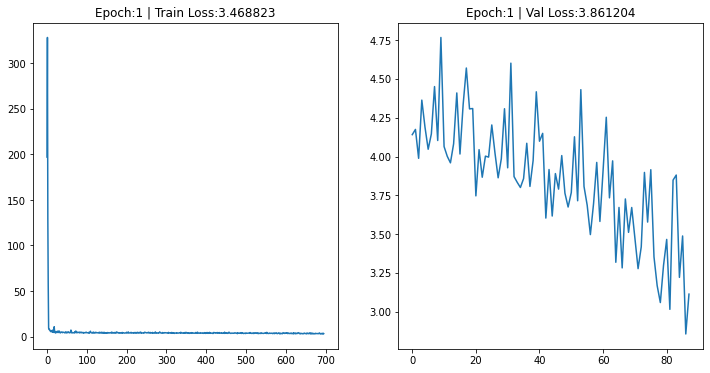

Truth उपलब्ध Pred 


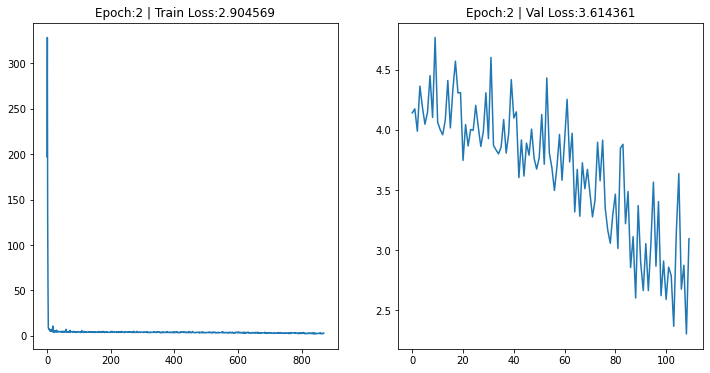

Truth गंदगी Pred 


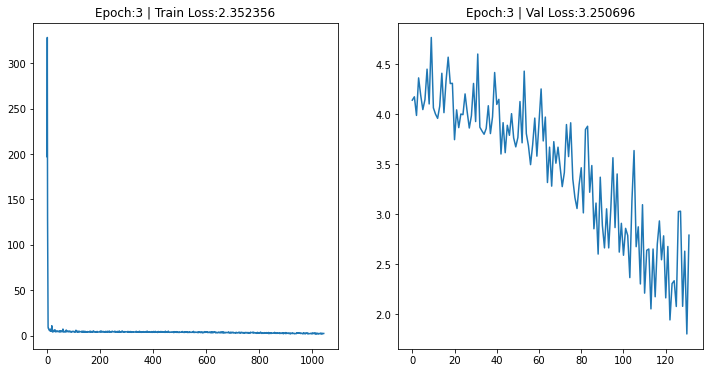

Truth चाट Pred 


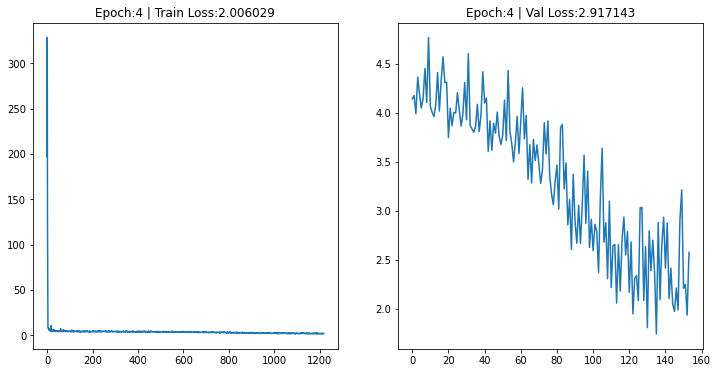

Truth प्रवेश Pred 


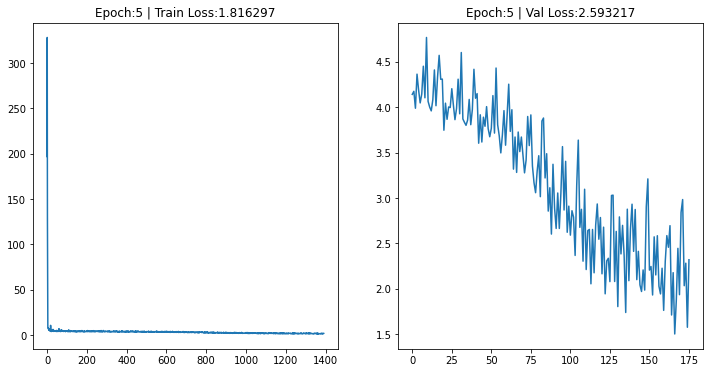

Truth मध्य Pred 


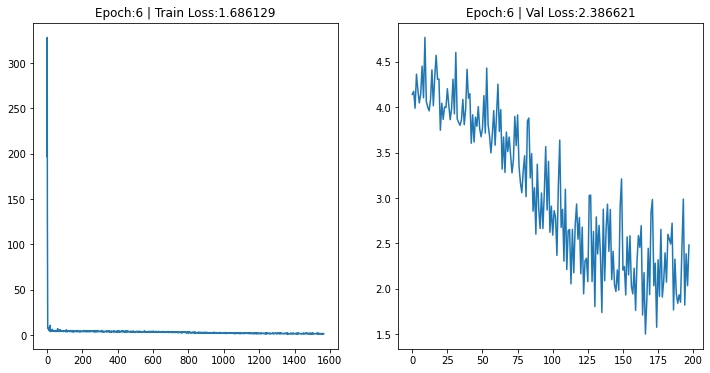

Truth में Pred 


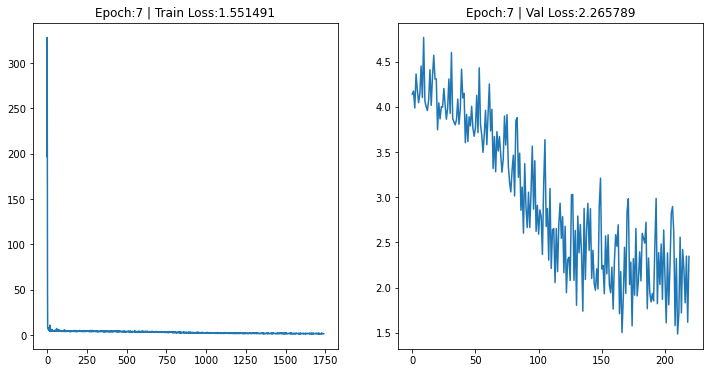

Truth इटारसी Pred 


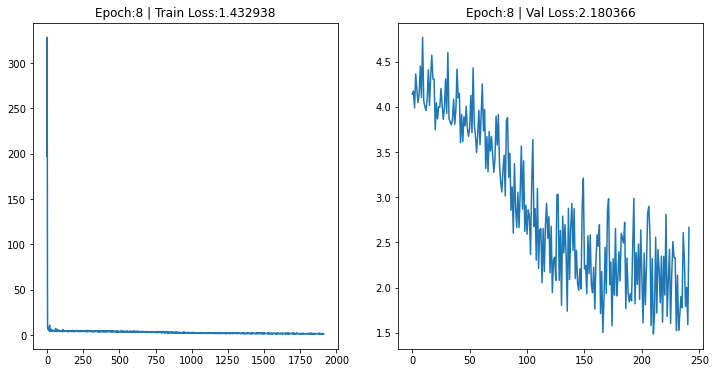

Truth गगनमगन Pred 


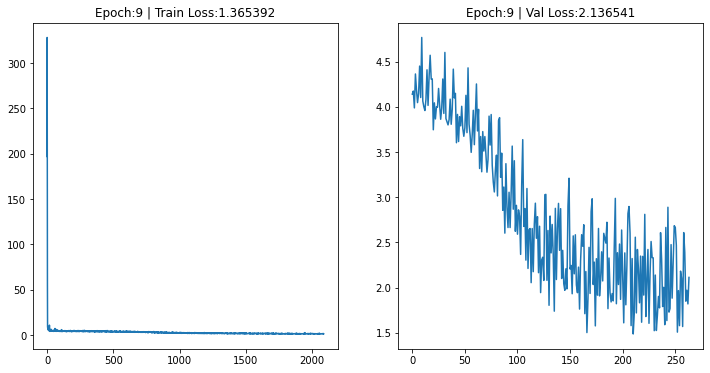

Truth परिसर Pred 


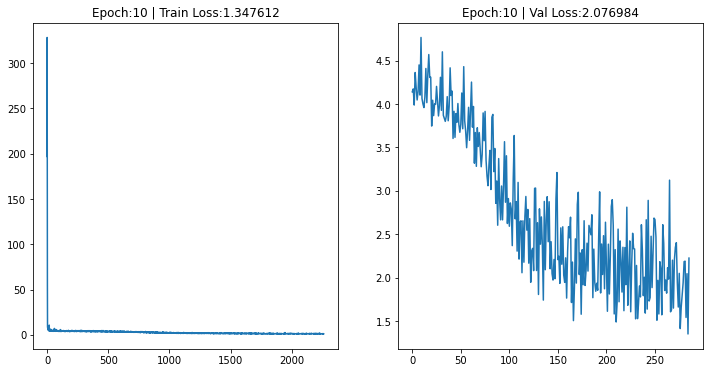

Truth कैरिज Pred 


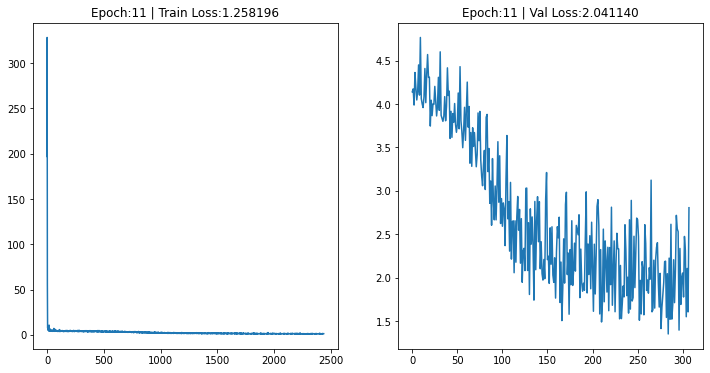

Truth लाफ Pred 


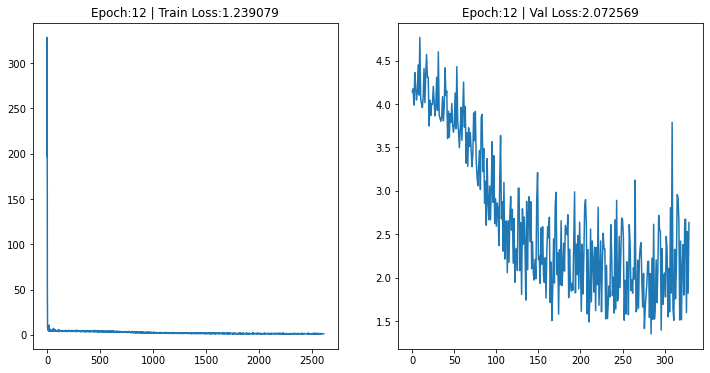

Truth सपना Pred 


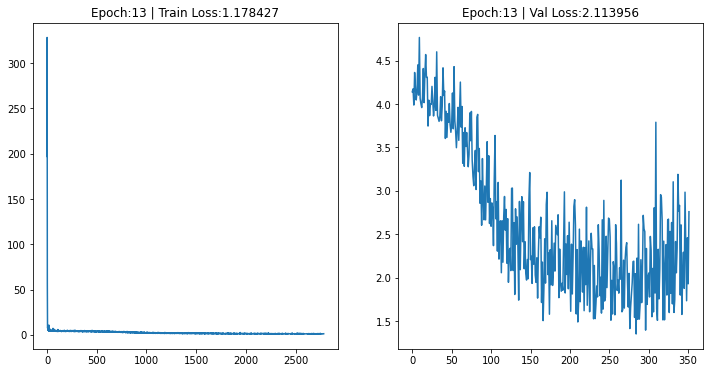

Truth एवं Pred 


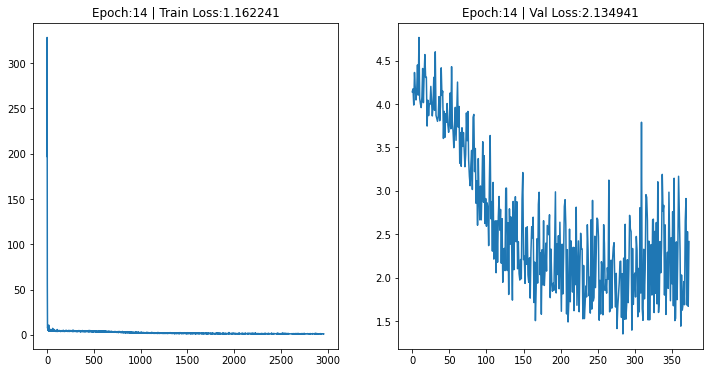

Truth श्रेणी Pred 
Epoch    18: reducing learning rate of group 0 to 2.0000e-03.


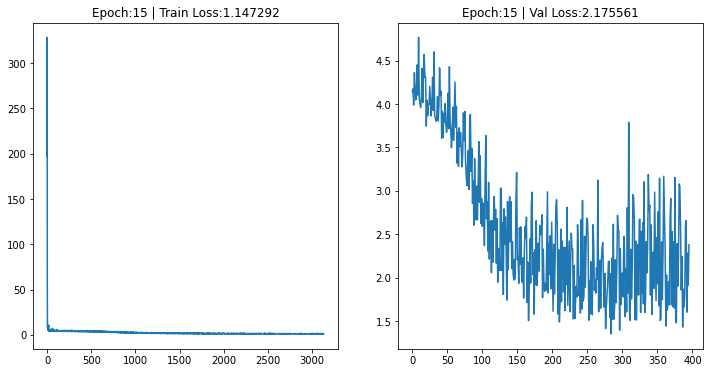

Truth सौन्दर्य Pred 


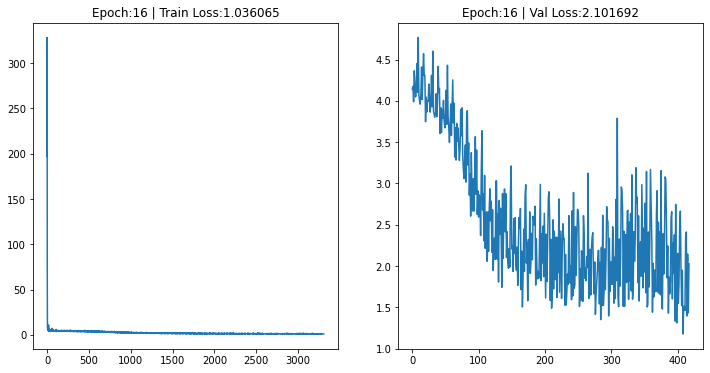

Truth गुर्रा Pred 


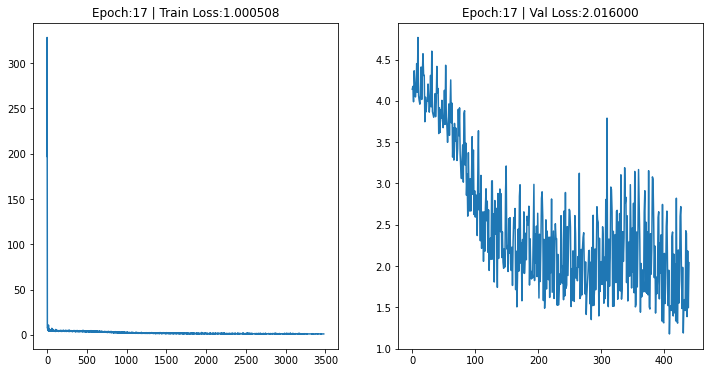

Truth मंडल Pred 


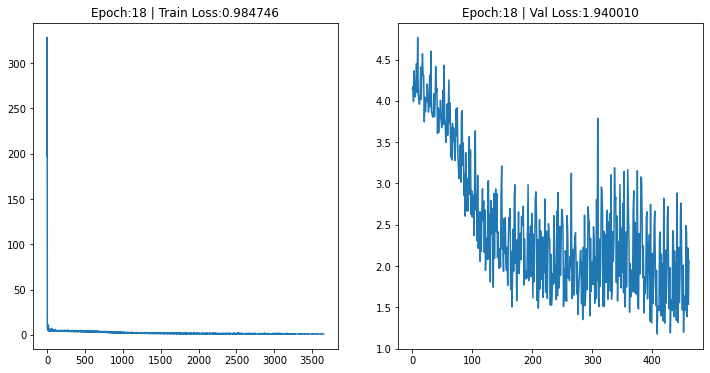

Truth पानी Pred 


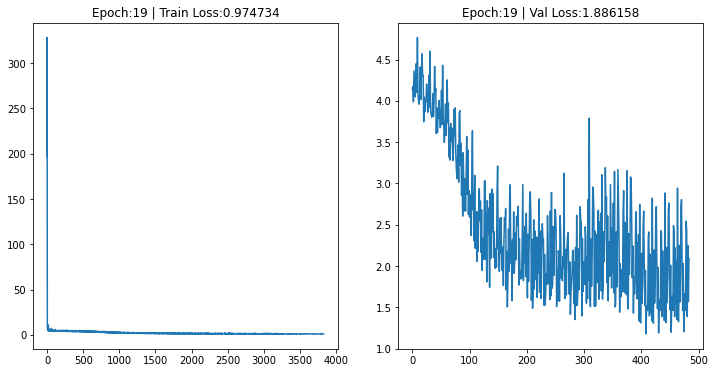

Truth खुलने Pred 


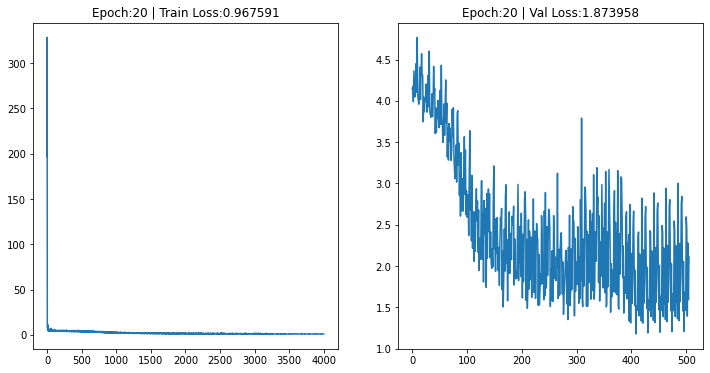

Truth चौबे Pred 


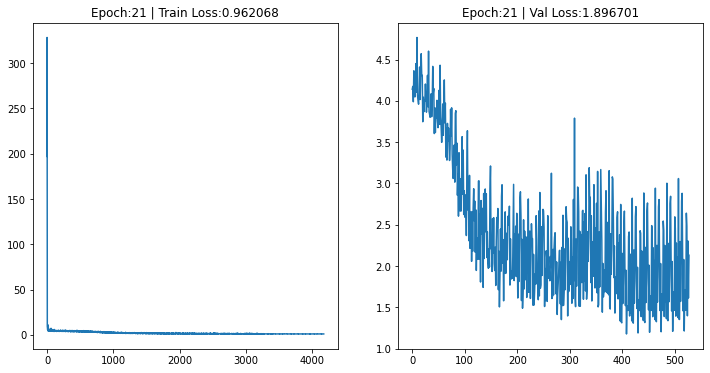

Truth विंध्याचल Pred 
Epoch    25: reducing learning rate of group 0 to 2.0000e-04.


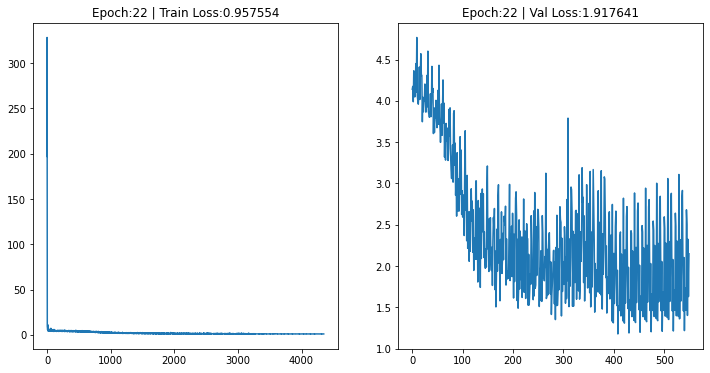

Truth का Pred 


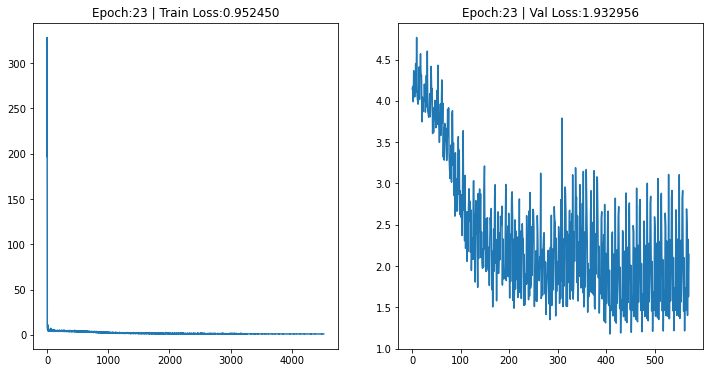

Truth स्वास्थ्य Pred 


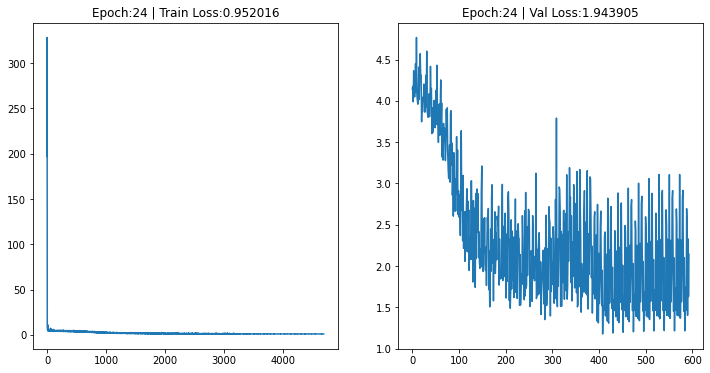

Truth स्टेशनरी Pred 


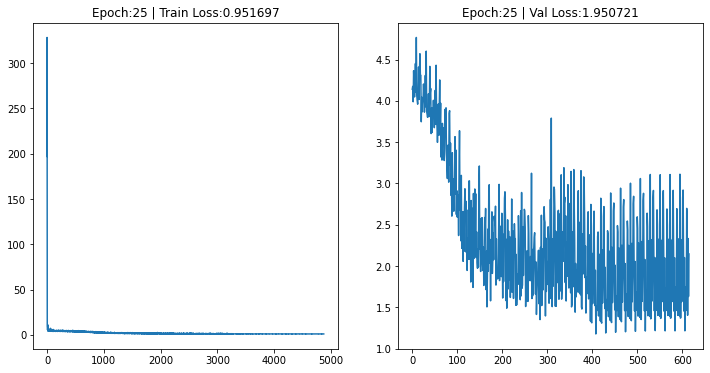

Truth कुमार Pred 


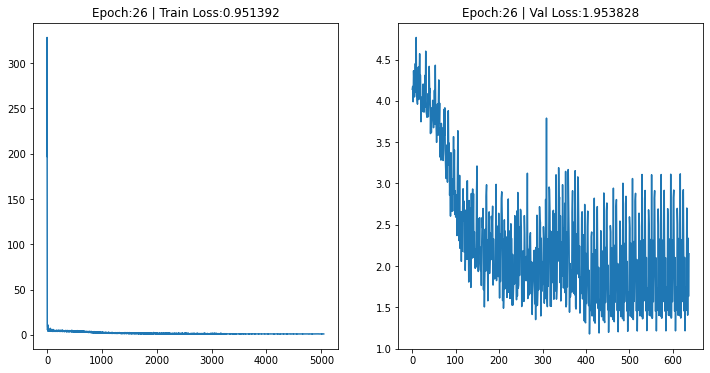

Truth चाट Pred 


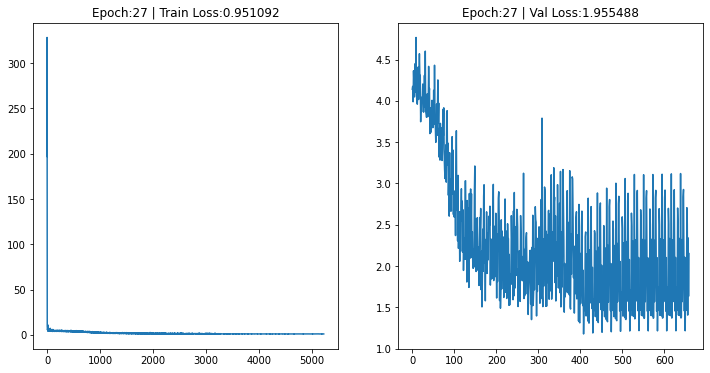

Truth अन्य Pred 
Epoch    31: reducing learning rate of group 0 to 2.0000e-05.


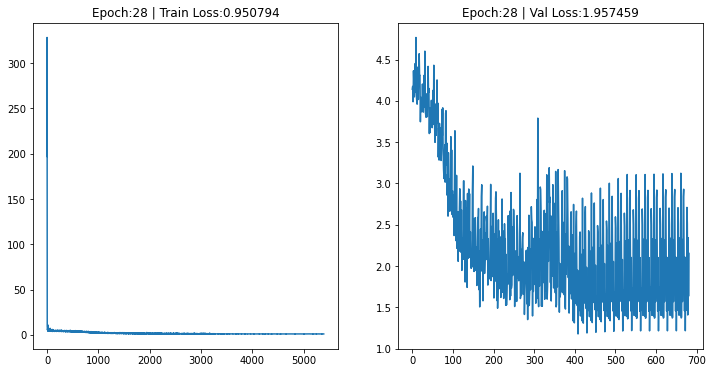

Truth दिव्यांग Pred 


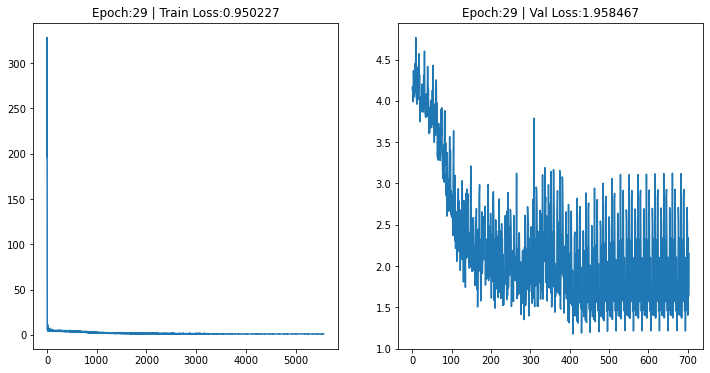

Truth स्टेशनरी Pred 


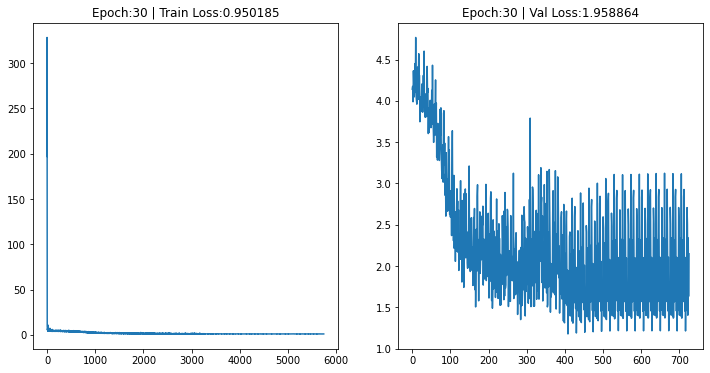

Truth भोपाल Pred 


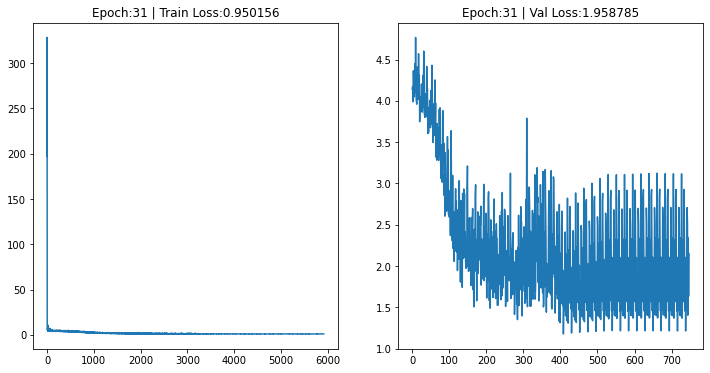

Truth तकनीकी Pred 


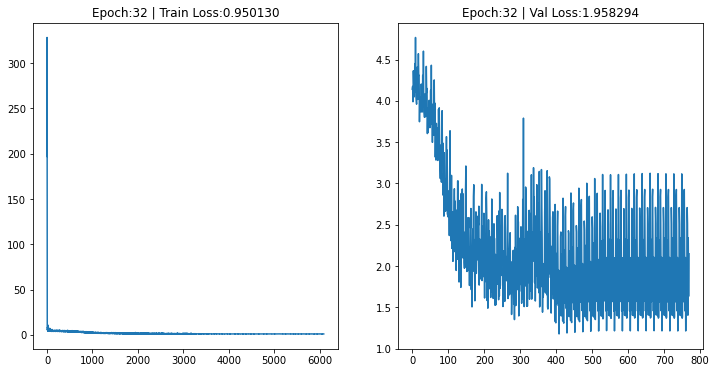

Truth व Pred 


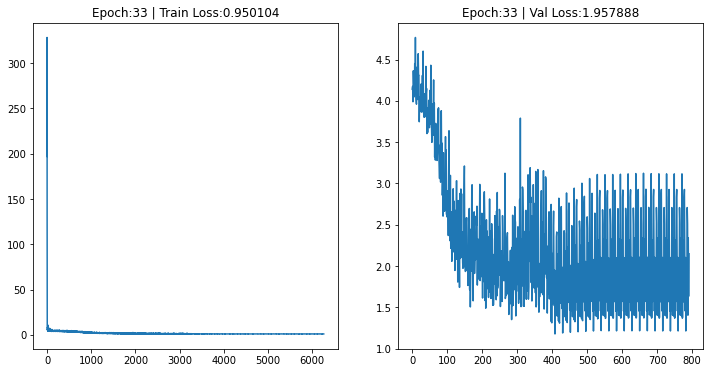

Truth वरिष्ठ Pred 
Epoch    37: reducing learning rate of group 0 to 2.0000e-06.


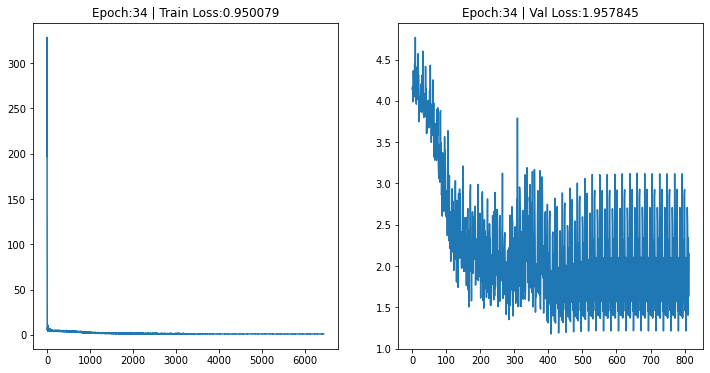

Truth इटारसी Pred 


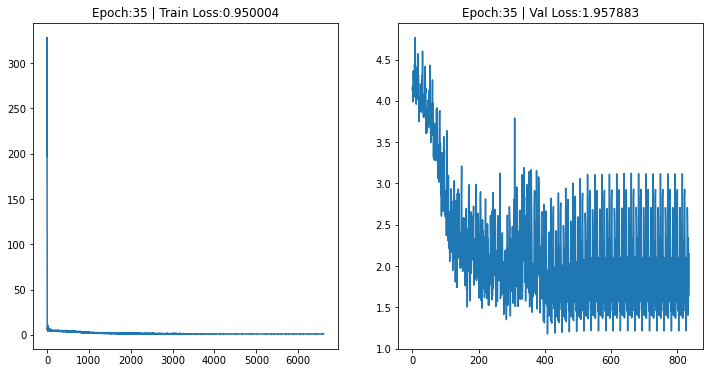

Truth वैगन Pred 


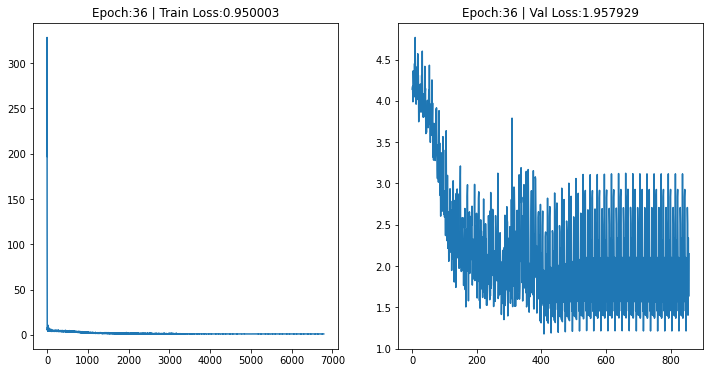

Truth पेय Pred 


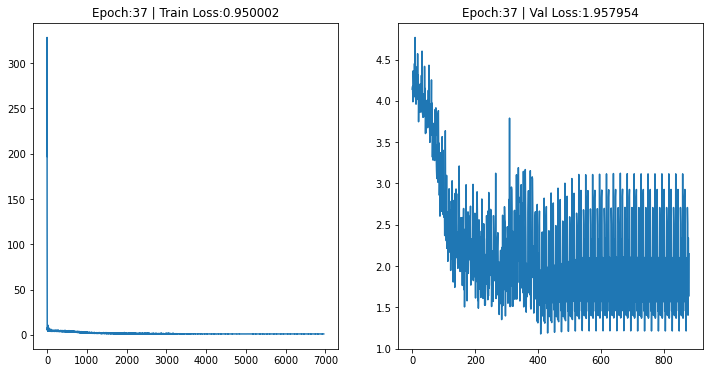

Truth नही Pred 


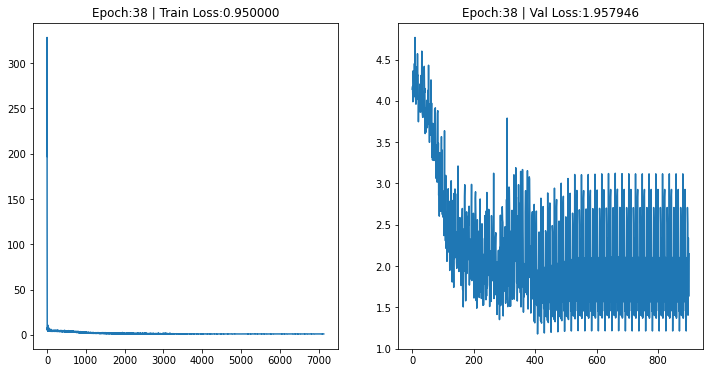

Truth साई Pred 


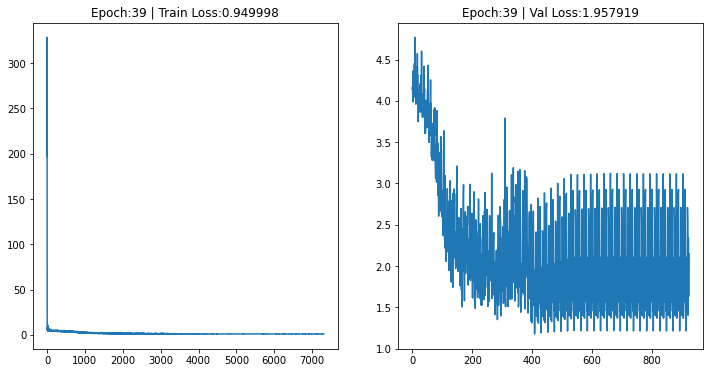

Truth ई Pred 
Epoch    43: reducing learning rate of group 0 to 2.0000e-07.


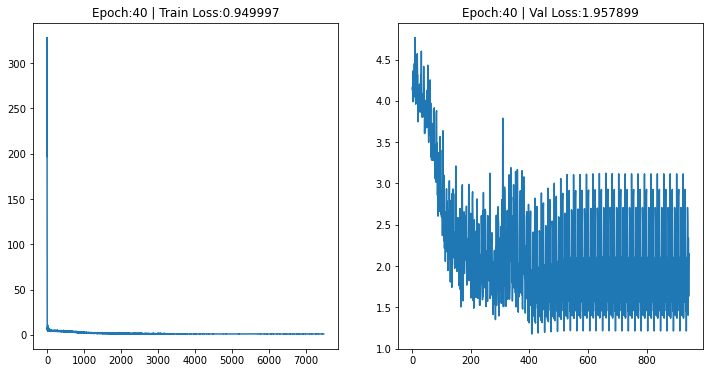

Truth स्वस्थ Pred 


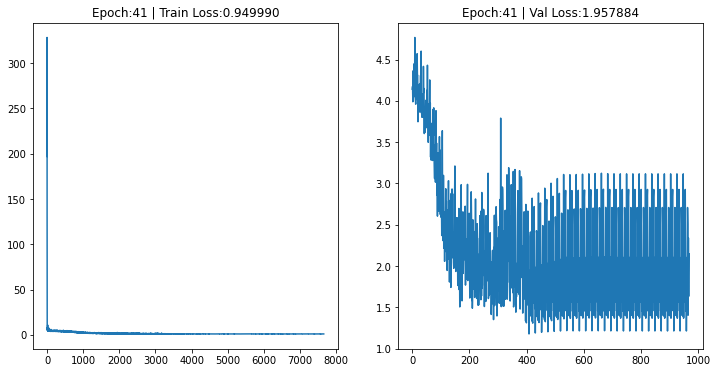

Truth चेन्नै Pred 


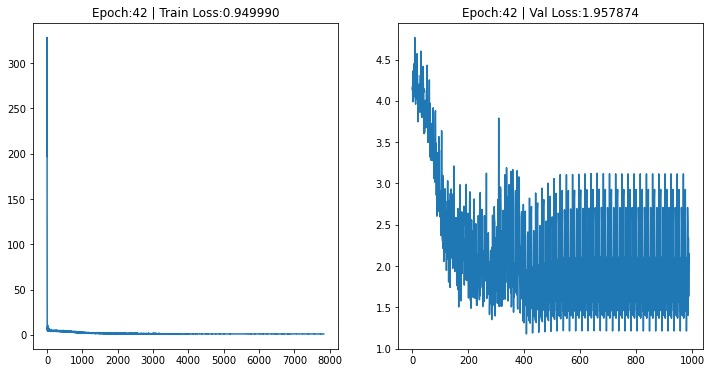

Truth गौरवपूर्ण Pred 


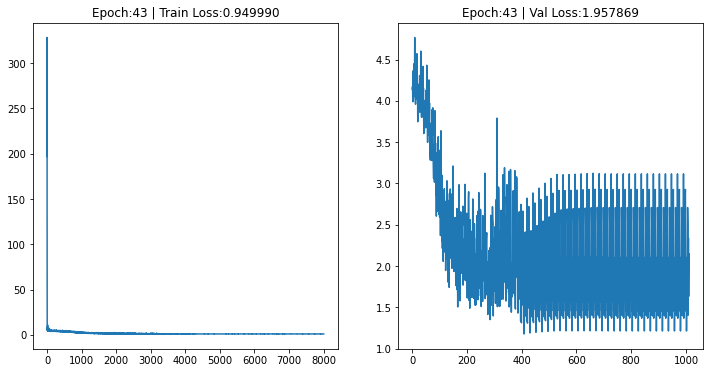

Truth इटारसी Pred 


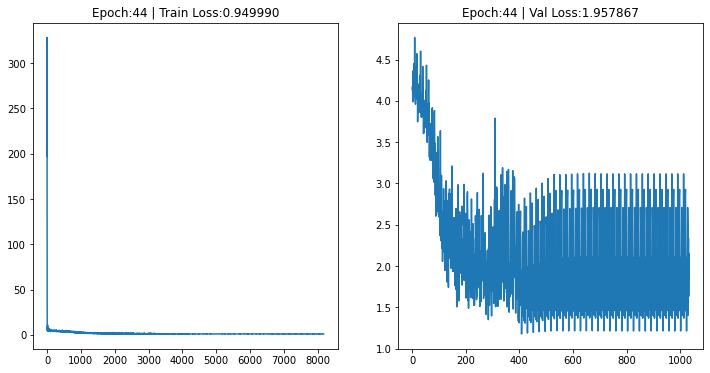

Truth एस Pred 


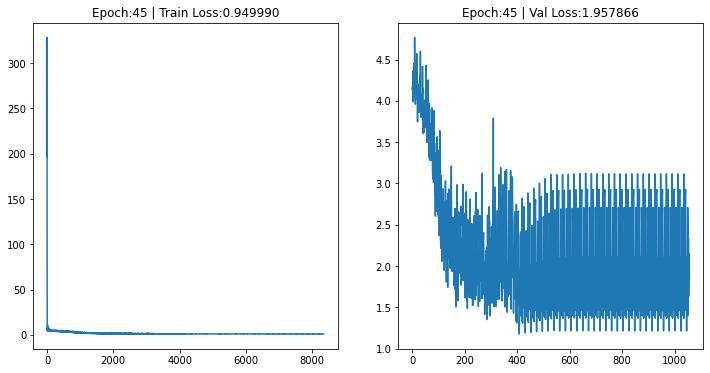

Truth एवं Pred 


In [0]:
try:
  epoch = 0
  while epoch<=max_epoch:
    rcnn.train()
    x = 0
    #print("Epoch: ",epoch)
    for batch_id, data in enumerate(train_loader):
      x += batch_size
      inputs, label = data

      
      #%%%%%%%%Preprocessing%%%%%%%%%%%%%%%%%
      
      
      #print("Input data shape",inputs.shape)
      npimg = (inputs).numpy()
      new_array = np.transpose(npimg,(0,3,1,2))
      new_array = torch.from_numpy(new_array)
      new_array = new_array.type(torch.FloatTensor)
      #print(new_array.shape)
      
      
      #%%%%%%%%%%%%%Forward%%%%%%%%%%%%%%%%%%%%
      
      
      outputs = rcnn(new_array.to(device))
      #print(outputs.shape)
      texts = label 
      loss = calculate_loss(outputs[0],texts)
      if np.isnan(loss.detach().cpu().numpy()):
        print("Dunno why this is here")
        continue
      train_losses.append(loss.item())
      #if(x%batch_size==0):
      #  print("Epoch: ",epoch,str(x)+"/"+str(len(train_data)), " Loss",loss.item())


      #%%%%%%%%%%%%%%%%%%Backward%%%%%%%%%%%%%  


      
      optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_norm_(rcnn.parameters(), clip_norm)
      optimizer.step()
      

    val_losses = validation(rcnn,val_losses)
    '''
    acc = accuracy_check(rcnn,validation_data)
    mean = sum(val_losses)/len(val_losses)
    validation_losses.append(mean)
    print(acc)
    print("Epoch:",epoch,"Mean:",mean)
    '''
    scheduler.step(val_losses[-1])
    plot_loss(epoch, train_losses, val_losses)
    print_prediction(rcnn, validation_data, device)
    epoch += 1
  print(validation_losses)
except KeyboardInterrupt:
  pass

In [0]:
npimg = np.asarray(training_data[101][0])
new_array = np.transpose(npimg,(2,0,1))
new_array = torch.from_numpy(new_array)
new_array = new_array.type(torch.FloatTensor)
new_array = new_array.unsqueeze(0)
output = rcnn(new_array.to(device))
print("Model ran Successfully!")
print(output[0].shape)
plt.imshow(output[1][0, 5, :, :].cpu().detach().numpy())
cv2_imshow(training_data[101][0])

In [0]:
torch.save(rcnn,'model1.pt')


In [0]:
def print_prediction(model, dataset, device):
    idx = np.random.randint(len(dataset))
    #path = dataset.pathes[idx]
    
    with torch.no_grad():
        model.eval()
        img, target_text = dataset[idx]
        image = img
        new_array = np.transpose(img,(2,0,1))
        new_array = torch.from_numpy(new_array)
        new_array = new_array.type(torch.FloatTensor)
        logits = model(new_array.unsqueeze(0).to(device))

    pred_text = decode_prediction(logits[0])
    print("Truth",target_text,"Pred",pred_text)

In [0]:
def plot_loss(epoch: int, 
              train_losses: list, 
              val_losses: list, 
              n_steps: int = 100):
    """
    Plots train and validation losses 
    """
    # clear previous graph
    #clear_output(True)
    # making titles
    train_title = f'Epoch:{epoch} | Train Loss:{np.mean(train_losses[-n_steps:]):.6f}'
    val_title = f'Epoch:{epoch} | Val Loss:{np.mean(val_losses[-n_steps:]):.6f}'

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(train_losses)
    ax[1].plot(val_losses)

    ax[0].set_title(train_title)
    ax[1].set_title(val_title)

    plt.show()


    #img = np.asarray(Image.open(path).convert('L'))
    #title = f'Truth: {target_text} | Pred: {pred_text}'
    #plt.imshow(img)
    #plt.title(title)
    #plt.axis('off');

In [0]:
def decode_prediction(logits):
    #print(logits.shape)
    tokens = logits.softmax(2).argmax(2)
    tokens = tokens.cpu()
    tokens = tokens.squeeze(1).numpy()
    # convert tor stings tokens
    
    tokens = ''.join([hindi_alpha2index[token] 
                      if token != 0  else '-' 
                      for token in tokens])
    tokens = tokens.split('-')
    #print(tokens)
    # remove duplicates

    text = [char 
            for batch_token in tokens 
            for idx, char in enumerate(batch_token)
            if char != batch_token[idx-1] or len(batch_token) == 1]
    text = ''.join(text)
 
    return text

In [0]:
model_1 = torch.load('model1.pt')

In [0]:
model_1

In [0]:
def accuracy_check(model,dataset):
    acc = 0
    for idx in range(len(dataset)):
      img, text = dataset[idx]
      new_array = np.transpose(img,(2,1,0))
      new_array = torch.from_numpy(new_array)
      new_array = new_array.type(torch.FloatTensor)
      logits = model(new_array.unsqueeze(0).to(device))
      pred_text = decode_prediction(logits)
      correct = 0
      pred_text = list(pred_text)
      text = list(text)
      if len(pred_text) != 0:
        for i in range(len(pred_text)):
          if i == len(text):
            break
          if pred_text[i] == text[i]:
            correct+=1        
        acc += correct/len(text)
      print(''.join(pred_text),''.join(text),correct/len(text))
    return acc/len(dataset)
    

In [0]:
acc2 = accuracy_check(model_1,train_data)
print(acc2)

In [0]:
model_1 = rcnn
acc2 = accuracy_check(model_1,train_data)
acc3 = accuracy_check(model_1,validation_data)
acc1 = accuracy_check(model_1,test_data)
print("Train Accuracy",acc2)
print("Validation Accuracy",acc3)
print("Test Accuracy",acc1)

RuntimeError: ignored

In [0]:

correct = 0
for idx in range(len(test_data)):
  print("----Image----")
  img, text = test_data[idx]
  cv2_imshow(img)
  print("Actual Output",text)
  new_array = np.transpose(img,(2,1,0))
  new_array = torch.from_numpy(new_array)
  new_array = new_array.type(torch.FloatTensor)
  logits = model_1(new_array.unsqueeze(0).to(device))
  pred_text = decode_prediction(logits)
  if pred_text== text:
    correct+=1
    #print("Correct")
  print("Predicted Output",pred_text)
print("Accuracy",correct/len(test_data))